Mount Google Drive to access saved models, images, and logs.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install the Ultralytics library

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

To use EfficientNet models, install efficientnet-pytorch.

In [ ]:
!pip install efficientnet-pytorch

facenet-pytorch provides pre-trained models for face detection and recognition in PyTorch.

In [ ]:
!pip install facenet-pytorch

Install the `pytz` library, which provides time zone support for accurately formatting timestamps (for Saudi Arabia time).

In [ ]:
!pip install pytz

Import necessary libraries and load the YOLOv8 and EfficientNet-B4 models from Google Drive.

In [ ]:
from ultralytics import YOLO
import torch

# Automatically select device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Using device:", device)

# Load YOLOv8 model
yolo_model_path = "/content/drive/MyDrive/Final_codes/train_with_60_epochs_and_0.01_lr0_and_cos_lr/weights/best.pt"
yolo_model = YOLO(yolo_model_path)
print(" YOLOv8 model loaded")

# Load the model architecture (EfficientNet-B4)
age_model = torch.load("/content/drive/MyDrive/EfficientNet__models/efficientnet_b4_model.pth", map_location=device, weights_only=False)
# Move model to the appropriate device
age_model.to(device)
age_model.eval()

print("EfficientNet-B4 model loaded")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
 Using device: cpu
 YOLOv8 model loaded
EfficientNet-B4 model loaded


This cell loads required libraries, sets paths and parameters for detection and alerting, initializes the face detector (MTCNN), and defines helper functions such as image upload to Imgur and age model preprocessing.

In [ ]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import torchvision.transforms as transforms
from facenet_pytorch import MTCNN
import requests
import urllib.parse
import csv
from datetime import datetime
import pytz
from shapely.geometry import box as shapely_box

# Paths and Parameters
log_path = "/content/drive/MyDrive/logs/alerts_log.csv"
image_folder = "/content/drive/MyDrive/sampleImages/sampleImages"
client_id = "880e3fbeaf9d64a"                 # Imgur Client ID
phone_number = "+966545632522"                # WhatsApp phone number
api_key = "4002985"                           # CallMeBot API key
age_classes = {0: "0-6", 1: "7-14"}
class_names = {0: "adult", 1: "kid", 2: "pet"}
riyadh_tz = pytz.timezone('Asia/Riyadh')

# Ensure log folder exists and CSV file is created
os.makedirs(os.path.dirname(log_path), exist_ok=True)
try:
    with open(log_path, mode='x', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Camera_id", "Phone_number", "Time", "Children", "Ages", "Pets"])
except FileExistsError:
    pass

# Function: Upload image to Imgur
def upload_to_imgur(image_path, client_id):
    headers = {'Authorization': f'Client-ID {client_id}'}
    with open(image_path, 'rb') as img_file:
        response = requests.post("https://api.imgur.com/3/image", headers=headers, files={'image': img_file})
    if response.status_code == 200:
        return response.json()['data']['link']
    else:
        print("Upload failed:", response.json())
        return None

# Prepare transform for age model
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((380, 380)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize MTCNN (face detector)
mtcnn = MTCNN(keep_all=True, device=device)

- Load sample images.
- Detect adults, children, and pets using YOLOv8.
- If no adult is detected, classify the age of each detected child using EfficientNet-B4.
- Upload alert images to Imgur.
- Send WhatsApp alerts if children or pets are found alone.
- Log all alerts to a CSV file.

**Test 10 imges (From 1 to 10)**

In [ ]:

# Load images: first 10 samples
image_paths = [os.path.join(image_folder, f"sample{i}.jpg") for i in range(1, 11)]

# Process each image
for image_path in image_paths:
    print(f"\nProcessing: {os.path.basename(image_path)}")
    img = cv2.imread(image_path)
    if img is None:
        print("Could not load image.")
        continue

    results = yolo_model(image_path)
    detected_kids = []
    detected_pets = []
    adult_present = False
    kid_ages = []

    vis_img = img.copy()

    if results[0].boxes is not None and len(results[0].boxes) > 0:
        detections = results[0].boxes.data.cpu().numpy()

        # Remove duplicate overlapping boxes (e.g., same-class IoU > 0.9)
        unique_detections = []
        for i, box_i in enumerate(detections):
            duplicate = False
            for j, box_j in enumerate(detections):
                if i != j and int(box_i[5]) == int(box_j[5]):
                    i_box = shapely_box(*box_i[:4])
                    j_box = shapely_box(*box_j[:4])
                    iou = i_box.intersection(j_box).area / i_box.union(j_box).area
                    if iou > 0.9:
                        duplicate = True
                        break
            if not duplicate:
                unique_detections.append(box_i)

        detections = unique_detections

        # Separate boxes by class
        kid_boxes = []
        adult_boxes = []
        pet_boxes = []

        for box in detections:
            x1, y1, x2, y2, conf, cls = box
            cls = int(cls)
            if cls == 0:
                adult_boxes.append((x1, y1, x2, y2, conf))
            elif cls == 1:
                kid_boxes.append((x1, y1, x2, y2, conf))
            elif cls == 2:
                pet_boxes.append((x1, y1, x2, y2, conf))

        # Filter overlapping adults
        filtered_adults = []
        for ax1, ay1, ax2, ay2, aconf in adult_boxes:
            keep = True
            for kx1, ky1, kx2, ky2, _ in kid_boxes:
                box_a = shapely_box(ax1, ay1, ax2, ay2)
                box_k = shapely_box(kx1, ky1, kx2, ky2)
                iou = box_a.intersection(box_k).area / box_a.union(box_k).area
                if iou > 0.4:
                    keep = False
                    break
            if keep:
                filtered_adults.append((ax1, ay1, ax2, ay2, aconf))

        # Merge boxes again with class labels
        final_detections = []
        for x1, y1, x2, y2, conf in filtered_adults:
            final_detections.append((x1, y1, x2, y2, conf, 0))  # adult
        for x1, y1, x2, y2, conf in kid_boxes:
            final_detections.append((x1, y1, x2, y2, conf, 1))  # kid
        for x1, y1, x2, y2, conf in pet_boxes:
            final_detections.append((x1, y1, x2, y2, conf, 2))  # pet

        # Loop through final detections
        for box in final_detections:
            x1, y1, x2, y2, conf, cls = box
            cls = int(cls)
            confidence = round(float(conf) * 100, 2)

            print(f"Detected: {class_names[cls]} with {confidence:.2f}% confidence")
            color = (0, 255, 0) if cls == 0 else (255, 0, 0) if cls == 1 else (0, 0, 255)
            cv2.rectangle(vis_img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            (tw, th), _ = cv2.getTextSize(f"{class_names[cls]} {confidence:.2f}%", cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(vis_img, (int(x1), int(y1) - th - 10), (int(x1) + tw, int(y1)), color, -1)
            cv2.putText(vis_img, f"{class_names[cls]} {confidence:.2f}%", (int(x1), int(y1) - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

            if cls == 0:
                adult_present = True
            elif cls == 1:
                expand_ratio = 0.2
                box_w = x2 - x1
                box_h = y2 - y1
                new_x1 = max(int(x1 - expand_ratio * box_w), 0)
                new_y1 = max(int(y1 - expand_ratio * box_h), 0)
                new_x2 = min(int(x2 + expand_ratio * box_w), img.shape[1])
                new_y2 = min(int(y2 + expand_ratio * box_h), img.shape[0])

                kid_crop = img[new_y1:new_y2, new_x1:new_x2]
                kid_crop_rgb = cv2.cvtColor(kid_crop, cv2.COLOR_BGR2RGB)
                boxes_face, _ = mtcnn.detect(Image.fromarray(kid_crop_rgb))

                if boxes_face is not None:
                    face_box = boxes_face[0]
                    fx1, fy1, fx2, fy2 = map(int, face_box)
                    fx1 = max(fx1, 0)
                    fy1 = max(fy1, 0)
                    fx2 = min(fx2, kid_crop.shape[1])
                    fy2 = min(fy2, kid_crop.shape[0])

                    face_crop = kid_crop[fy1:fy2, fx1:fx2]
                    detected_kids.append(face_crop)
                else:
                    print("No face detected inside kid box.")
                    detected_kids.append(None)
                    kid_ages.append("Unknown")
            elif cls == 2:
                detected_pets.append((x1, y1, x2, y2))

        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"YOLO Detections in {os.path.basename(image_path)}")
        plt.show()

        if adult_present:
            print("Adult detected — skipping age estimation and alerts.")
        else:
            if detected_kids or detected_pets:
                print("No adult detected — running age estimation for kids...")
                alert_triggered = False

                for idx, face in enumerate(detected_kids):
                    if face is None:
                        print(f"Kid {idx+1}: Face not detected — skipping age prediction.")
                        continue
                    try:
                        h, w = face.shape[:2]
                        if h < 80 or w < 80:
                            print(f"Kid {idx+1}: Face too small {face.shape}, resizing to 100x100.")
                            face = cv2.resize(face, (100, 100), interpolation=cv2.INTER_CUBIC)

                        face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                        face_tensor = transform(face_rgb).unsqueeze(0).to(device)

                        with torch.no_grad():
                            outputs = age_model(face_tensor)
                            probs = torch.nn.functional.softmax(outputs, dim=1)
                            confidence_age, preds = torch.max(probs, 1)

                        predicted_age = age_classes[preds.item()]
                        kid_ages.append(predicted_age)
                        print(f"Kid {idx+1}: Predicted age = {predicted_age} (EfficientNet confidence {confidence_age.item():.2f})")

                        if predicted_age in ["0-6", "7-14"]:
                            alert_triggered = True

                        plt.figure(figsize=(4, 4))
                        plt.imshow(face_rgb)
                        plt.axis("off")
                        plt.title(f"Kid {idx+1}\nAge: {predicted_age}", fontsize=10)
                        plt.show()

                    except Exception as e:
                        print(f"Failed to predict age for kid {idx+1}: {str(e)}")

                if alert_triggered or detected_pets:
                    uploaded_image_url = upload_to_imgur(image_path, client_id)

                    alert_msg = "[Child Alert System] 🔴 "
                    if detected_kids:
                        alert_msg += f"{len(detected_kids)} child(ren) detected alone in the car (Ages: {', '.join(kid_ages)}).\n "
                    if detected_pets:
                        alert_msg += f"{len(detected_pets)} pet(s) detected alone in the car. "
                    alert_msg += f"Image: {uploaded_image_url}"

                    print("\nALERT MESSAGE:\n", alert_msg)

                    encoded_msg = urllib.parse.quote(alert_msg)
                    whatsapp_url = f"https://api.callmebot.com/whatsapp.php?phone={phone_number}&text={encoded_msg}&apikey={api_key}"
                    print("\nSending WhatsApp alert...")
                    response = requests.get(whatsapp_url)
                    print("Status:", response.status_code)

                    timestamp = datetime.now(riyadh_tz).strftime("%Y-%m-%d %H:%M:%S")
                    with open(log_path, mode='a', newline='') as file:
                        writer = csv.writer(file)
                        writer.writerow(["Camera_1", phone_number, timestamp, len(detected_kids), ', '.join(kid_ages), len(detected_pets)])
            else:
                print("No kids or pets detected — no alert needed.")

    else:
        print("No objects detected.")

**Test 10 imges (From 11 to 20)**

In [ ]:
# Load images: 11 to 20 samples
image_paths = [os.path.join(image_folder, f"sample{i}.jpg") for i in range(11, 21)]

# Process each image
for image_path in image_paths:
    print(f"\nProcessing: {os.path.basename(image_path)}")
    img = cv2.imread(image_path)
    if img is None:
        print("Could not load image.")
        continue

    results = yolo_model(image_path)
    detected_kids = []
    detected_pets = []
    adult_present = False
    kid_ages = []

    vis_img = img.copy()

    if results[0].boxes is not None and len(results[0].boxes) > 0:
        detections = results[0].boxes.data.cpu().numpy()

        # Remove duplicate overlapping boxes (e.g., same-class IoU > 0.9)
        unique_detections = []
        for i, box_i in enumerate(detections):
            duplicate = False
            for j, box_j in enumerate(detections):
                if i != j and int(box_i[5]) == int(box_j[5]):
                    i_box = shapely_box(*box_i[:4])
                    j_box = shapely_box(*box_j[:4])
                    iou = i_box.intersection(j_box).area / i_box.union(j_box).area
                    if iou > 0.9:
                        duplicate = True
                        break
            if not duplicate:
                unique_detections.append(box_i)

        detections = unique_detections

        # Separate boxes by class
        kid_boxes = []
        adult_boxes = []
        pet_boxes = []

        for box in detections:
            x1, y1, x2, y2, conf, cls = box
            cls = int(cls)
            if cls == 0:
                adult_boxes.append((x1, y1, x2, y2, conf))
            elif cls == 1:
                kid_boxes.append((x1, y1, x2, y2, conf))
            elif cls == 2:
                pet_boxes.append((x1, y1, x2, y2, conf))

        # Filter overlapping adults
        filtered_adults = []
        for ax1, ay1, ax2, ay2, aconf in adult_boxes:
            keep = True
            for kx1, ky1, kx2, ky2, _ in kid_boxes:
                box_a = shapely_box(ax1, ay1, ax2, ay2)
                box_k = shapely_box(kx1, ky1, kx2, ky2)
                iou = box_a.intersection(box_k).area / box_a.union(box_k).area
                if iou > 0.4:
                    keep = False
                    break
            if keep:
                filtered_adults.append((ax1, ay1, ax2, ay2, aconf))

        # Merge boxes again with class labels
        final_detections = []
        for x1, y1, x2, y2, conf in filtered_adults:
            final_detections.append((x1, y1, x2, y2, conf, 0))  # adult
        for x1, y1, x2, y2, conf in kid_boxes:
            final_detections.append((x1, y1, x2, y2, conf, 1))  # kid
        for x1, y1, x2, y2, conf in pet_boxes:
            final_detections.append((x1, y1, x2, y2, conf, 2))  # pet

        # Loop through final detections
        for box in final_detections:
            x1, y1, x2, y2, conf, cls = box
            cls = int(cls)
            confidence = round(float(conf) * 100, 2)

            print(f"Detected: {class_names[cls]} with {confidence:.2f}% confidence")
            color = (0, 255, 0) if cls == 0 else (255, 0, 0) if cls == 1 else (0, 0, 255)
            cv2.rectangle(vis_img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            (tw, th), _ = cv2.getTextSize(f"{class_names[cls]} {confidence:.2f}%", cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(vis_img, (int(x1), int(y1) - th - 10), (int(x1) + tw, int(y1)), color, -1)
            cv2.putText(vis_img, f"{class_names[cls]} {confidence:.2f}%", (int(x1), int(y1) - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

            if cls == 0:
                adult_present = True
            elif cls == 1:
                expand_ratio = 0.2
                box_w = x2 - x1
                box_h = y2 - y1
                new_x1 = max(int(x1 - expand_ratio * box_w), 0)
                new_y1 = max(int(y1 - expand_ratio * box_h), 0)
                new_x2 = min(int(x2 + expand_ratio * box_w), img.shape[1])
                new_y2 = min(int(y2 + expand_ratio * box_h), img.shape[0])

                kid_crop = img[new_y1:new_y2, new_x1:new_x2]
                kid_crop_rgb = cv2.cvtColor(kid_crop, cv2.COLOR_BGR2RGB)
                boxes_face, _ = mtcnn.detect(Image.fromarray(kid_crop_rgb))

                if boxes_face is not None:
                    face_box = boxes_face[0]
                    fx1, fy1, fx2, fy2 = map(int, face_box)
                    fx1 = max(fx1, 0)
                    fy1 = max(fy1, 0)
                    fx2 = min(fx2, kid_crop.shape[1])
                    fy2 = min(fy2, kid_crop.shape[0])

                    face_crop = kid_crop[fy1:fy2, fx1:fx2]
                    detected_kids.append(face_crop)
                else:
                    print("No face detected inside kid box.")
                    detected_kids.append(None)
                    kid_ages.append("Unknown")
            elif cls == 2:
                detected_pets.append((x1, y1, x2, y2))

        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"YOLO Detections in {os.path.basename(image_path)}")
        plt.show()

        if adult_present:
            print("Adult detected — skipping age estimation and alerts.")
        else:
            if detected_kids or detected_pets:
                print("No adult detected — running age estimation for kids...")
                alert_triggered = False

                for idx, face in enumerate(detected_kids):
                    if face is None:
                        print(f"Kid {idx+1}: Face not detected — skipping age prediction.")
                        continue
                    try:
                        h, w = face.shape[:2]
                        if h < 80 or w < 80:
                            print(f"Kid {idx+1}: Face too small {face.shape}, resizing to 100x100.")
                            face = cv2.resize(face, (100, 100), interpolation=cv2.INTER_CUBIC)

                        face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                        face_tensor = transform(face_rgb).unsqueeze(0).to(device)

                        with torch.no_grad():
                            outputs = age_model(face_tensor)
                            probs = torch.nn.functional.softmax(outputs, dim=1)
                            confidence_age, preds = torch.max(probs, 1)

                        predicted_age = age_classes[preds.item()]
                        kid_ages.append(predicted_age)
                        print(f"Kid {idx+1}: Predicted age = {predicted_age} (EfficientNet confidence {confidence_age.item():.2f})")

                        if predicted_age in ["0-6", "7-14"]:
                            alert_triggered = True

                        plt.figure(figsize=(4, 4))
                        plt.imshow(face_rgb)
                        plt.axis("off")
                        plt.title(f"Kid {idx+1}\nAge: {predicted_age}", fontsize=10)
                        plt.show()

                    except Exception as e:
                        print(f"Failed to predict age for kid {idx+1}: {str(e)}")

                if alert_triggered or detected_pets:
                    uploaded_image_url = upload_to_imgur(image_path, client_id)

                    alert_msg = "[Child Alert System] 🔴 "
                    if detected_kids:
                        alert_msg += f"{len(detected_kids)} child(ren) detected alone in the car (Ages: {', '.join(kid_ages)}).\n "
                    if detected_pets:
                        alert_msg += f"{len(detected_pets)} pet(s) detected alone in the car. "
                    alert_msg += f"Image: {uploaded_image_url}"

                    print("\nALERT MESSAGE:\n", alert_msg)

                    encoded_msg = urllib.parse.quote(alert_msg)
                    whatsapp_url = f"https://api.callmebot.com/whatsapp.php?phone={phone_number}&text={encoded_msg}&apikey={api_key}"
                    print("\nSending WhatsApp alert...")
                    response = requests.get(whatsapp_url)
                    print("Status:", response.status_code)

                    timestamp = datetime.now(riyadh_tz).strftime("%Y-%m-%d %H:%M:%S")
                    with open(log_path, mode='a', newline='') as file:
                        writer = csv.writer(file)
                        writer.writerow(["Camera_1", phone_number, timestamp, len(detected_kids), ', '.join(kid_ages), len(detected_pets)])
            else:
                print("No kids or pets detected — no alert needed.")

    else:
        print("No objects detected.")

**Test 10 imges (From 21 to 30)**

In [ ]:
# Load images: samples 21 to 30
image_paths = [os.path.join(image_folder, f"sample{i}.jpg") for i in range(21, 31)]

# Process each image
for image_path in image_paths:
    print(f"\nProcessing: {os.path.basename(image_path)}")
    img = cv2.imread(image_path)
    if img is None:
        print("Could not load image.")
        continue

    results = yolo_model(image_path)
    detected_kids = []
    detected_pets = []
    adult_present = False
    kid_ages = []

    vis_img = img.copy()

    if results[0].boxes is not None and len(results[0].boxes) > 0:
        detections = results[0].boxes.data.cpu().numpy()

        # Remove duplicate overlapping boxes (e.g., same-class IoU > 0.9)
        unique_detections = []
        for i, box_i in enumerate(detections):
            duplicate = False
            for j, box_j in enumerate(detections):
                if i != j and int(box_i[5]) == int(box_j[5]):
                    i_box = shapely_box(*box_i[:4])
                    j_box = shapely_box(*box_j[:4])
                    iou = i_box.intersection(j_box).area / i_box.union(j_box).area
                    if iou > 0.9:
                        duplicate = True
                        break
            if not duplicate:
                unique_detections.append(box_i)

        detections = unique_detections

        # Separate boxes by class
        kid_boxes = []
        adult_boxes = []
        pet_boxes = []

        for box in detections:
            x1, y1, x2, y2, conf, cls = box
            cls = int(cls)
            if cls == 0:
                adult_boxes.append((x1, y1, x2, y2, conf))
            elif cls == 1:
                kid_boxes.append((x1, y1, x2, y2, conf))
            elif cls == 2:
                pet_boxes.append((x1, y1, x2, y2, conf))

        # Filter overlapping adults
        filtered_adults = []
        for ax1, ay1, ax2, ay2, aconf in adult_boxes:
            keep = True
            for kx1, ky1, kx2, ky2, _ in kid_boxes:
                box_a = shapely_box(ax1, ay1, ax2, ay2)
                box_k = shapely_box(kx1, ky1, kx2, ky2)
                iou = box_a.intersection(box_k).area / box_a.union(box_k).area
                if iou > 0.4:
                    keep = False
                    break
            if keep:
                filtered_adults.append((ax1, ay1, ax2, ay2, aconf))

        # Merge boxes again with class labels
        final_detections = []
        for x1, y1, x2, y2, conf in filtered_adults:
            final_detections.append((x1, y1, x2, y2, conf, 0))  # adult
        for x1, y1, x2, y2, conf in kid_boxes:
            final_detections.append((x1, y1, x2, y2, conf, 1))  # kid
        for x1, y1, x2, y2, conf in pet_boxes:
            final_detections.append((x1, y1, x2, y2, conf, 2))  # pet

        # Loop through final detections
        for box in final_detections:
            x1, y1, x2, y2, conf, cls = box
            cls = int(cls)
            confidence = round(float(conf) * 100, 2)

            print(f"Detected: {class_names[cls]} with {confidence:.2f}% confidence")
            color = (0, 255, 0) if cls == 0 else (255, 0, 0) if cls == 1 else (0, 0, 255)
            cv2.rectangle(vis_img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            (tw, th), _ = cv2.getTextSize(f"{class_names[cls]} {confidence:.2f}%", cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(vis_img, (int(x1), int(y1) - th - 10), (int(x1) + tw, int(y1)), color, -1)
            cv2.putText(vis_img, f"{class_names[cls]} {confidence:.2f}%", (int(x1), int(y1) - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

            if cls == 0:
                adult_present = True
            elif cls == 1:
                expand_ratio = 0.2
                box_w = x2 - x1
                box_h = y2 - y1
                new_x1 = max(int(x1 - expand_ratio * box_w), 0)
                new_y1 = max(int(y1 - expand_ratio * box_h), 0)
                new_x2 = min(int(x2 + expand_ratio * box_w), img.shape[1])
                new_y2 = min(int(y2 + expand_ratio * box_h), img.shape[0])

                kid_crop = img[new_y1:new_y2, new_x1:new_x2]
                kid_crop_rgb = cv2.cvtColor(kid_crop, cv2.COLOR_BGR2RGB)
                boxes_face, _ = mtcnn.detect(Image.fromarray(kid_crop_rgb))

                if boxes_face is not None:
                    face_box = boxes_face[0]
                    fx1, fy1, fx2, fy2 = map(int, face_box)
                    fx1 = max(fx1, 0)
                    fy1 = max(fy1, 0)
                    fx2 = min(fx2, kid_crop.shape[1])
                    fy2 = min(fy2, kid_crop.shape[0])

                    face_crop = kid_crop[fy1:fy2, fx1:fx2]
                    detected_kids.append(face_crop)
                else:
                    print("No face detected inside kid box.")
                    detected_kids.append(None)
                    kid_ages.append("Unknown")
            elif cls == 2:
                detected_pets.append((x1, y1, x2, y2))

        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"YOLO Detections in {os.path.basename(image_path)}")
        plt.show()

        if adult_present:
            print("Adult detected — skipping age estimation and alerts.")
        else:
            if detected_kids or detected_pets:
                print("No adult detected — running age estimation for kids...")
                alert_triggered = False

                for idx, face in enumerate(detected_kids):
                    if face is None:
                        print(f"Kid {idx+1}: Face not detected — skipping age prediction.")
                        alert_triggered = True
                        continue
                    try:
                        h, w = face.shape[:2]
                        if h < 80 or w < 80:
                            print(f"Kid {idx+1}: Face too small {face.shape}, resizing to 100x100.")
                            face = cv2.resize(face, (100, 100), interpolation=cv2.INTER_CUBIC)

                        face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                        face_tensor = transform(face_rgb).unsqueeze(0).to(device)

                        with torch.no_grad():
                            outputs = age_model(face_tensor)
                            probs = torch.nn.functional.softmax(outputs, dim=1)
                            confidence_age, preds = torch.max(probs, 1)

                        predicted_age = age_classes[preds.item()]
                        kid_ages.append(predicted_age)
                        print(f"Kid {idx+1}: Predicted age = {predicted_age} (EfficientNet confidence {confidence_age.item():.2f})")

                        if predicted_age in ["0-6", "7-14"]:
                            alert_triggered = True

                        plt.figure(figsize=(4, 4))
                        plt.imshow(face_rgb)
                        plt.axis("off")
                        plt.title(f"Kid {idx+1}\nAge: {predicted_age}", fontsize=10)
                        plt.show()

                    except Exception as e:
                        print(f"Failed to predict age for kid {idx+1}: {str(e)}")

                if alert_triggered or "Unknown" in kid_ages or detected_pets:
                    uploaded_image_url = upload_to_imgur(image_path, client_id)

                    alert_msg = "[Child Alert System] 🔴 "
                    if detected_kids:
                        alert_msg += f"{len(detected_kids)} child(ren) detected alone in the car (Ages: {', '.join(kid_ages)}).\n "
                    if detected_pets:
                        alert_msg += f"{len(detected_pets)} pet(s) detected alone in the car. "
                    alert_msg += f"Image: {uploaded_image_url}"

                    print("\nALERT MESSAGE:\n", alert_msg)

                    encoded_msg = urllib.parse.quote(alert_msg)
                    whatsapp_url = f"https://api.callmebot.com/whatsapp.php?phone={phone_number}&text={encoded_msg}&apikey={api_key}"
                    print("\nSending WhatsApp alert...")
                    response = requests.get(whatsapp_url)
                    print("Status:", response.status_code)

                    timestamp = datetime.now(riyadh_tz).strftime("%Y-%m-%d %H:%M:%S")
                    with open(log_path, mode='a', newline='') as file:
                        writer = csv.writer(file)
                        writer.writerow(["Camera_1", phone_number, timestamp, len(detected_kids), ', '.join(kid_ages), len(detected_pets)])
            else:
                print("No kids or pets detected — no alert needed.")

    else:
        print("No objects detected.")

In [ ]:

# Load images: samples 31 to 40
image_paths = [os.path.join(image_folder, f"sample{i}.jpg") for i in range(31, 41)]

# Process each image
for image_path in image_paths:
    print(f"\nProcessing: {os.path.basename(image_path)}")
    img = cv2.imread(image_path)
    if img is None:
        print("Could not load image.")
        continue

    results = yolo_model(image_path)
    detected_kids = []
    detected_pets = []
    adult_present = False
    kid_ages = []

    vis_img = img.copy()

    if results[0].boxes is not None and len(results[0].boxes) > 0:
        detections = results[0].boxes.data.cpu().numpy()

        # Remove duplicate overlapping boxes (e.g., same-class IoU > 0.9)
        unique_detections = []
        for i, box_i in enumerate(detections):
            duplicate = False
            for j, box_j in enumerate(detections):
                if i != j and int(box_i[5]) == int(box_j[5]):
                    i_box = shapely_box(*box_i[:4])
                    j_box = shapely_box(*box_j[:4])
                    iou = i_box.intersection(j_box).area / i_box.union(j_box).area
                    if iou > 0.9:
                        duplicate = True
                        break
            if not duplicate:
                unique_detections.append(box_i)

        detections = unique_detections

        # Separate boxes by class
        kid_boxes = []
        adult_boxes = []
        pet_boxes = []

        for box in detections:
            x1, y1, x2, y2, conf, cls = box
            cls = int(cls)
            if cls == 0:
                adult_boxes.append((x1, y1, x2, y2, conf))
            elif cls == 1:
                kid_boxes.append((x1, y1, x2, y2, conf))
            elif cls == 2:
                pet_boxes.append((x1, y1, x2, y2, conf))

        # Filter overlapping adults
        filtered_adults = []
        for ax1, ay1, ax2, ay2, aconf in adult_boxes:
            keep = True
            for kx1, ky1, kx2, ky2, _ in kid_boxes:
                box_a = shapely_box(ax1, ay1, ax2, ay2)
                box_k = shapely_box(kx1, ky1, kx2, ky2)
                iou = box_a.intersection(box_k).area / box_a.union(box_k).area
                if iou > 0.4:
                    keep = False
                    break
            if keep:
                filtered_adults.append((ax1, ay1, ax2, ay2, aconf))

        # Merge boxes again with class labels
        final_detections = []
        for x1, y1, x2, y2, conf in filtered_adults:
            final_detections.append((x1, y1, x2, y2, conf, 0))  # adult
        for x1, y1, x2, y2, conf in kid_boxes:
            final_detections.append((x1, y1, x2, y2, conf, 1))  # kid
        for x1, y1, x2, y2, conf in pet_boxes:
            final_detections.append((x1, y1, x2, y2, conf, 2))  # pet

        # Loop through final detections
        for box in final_detections:
            x1, y1, x2, y2, conf, cls = box
            cls = int(cls)
            confidence = round(float(conf) * 100, 2)

            print(f"Detected: {class_names[cls]} with {confidence:.2f}% confidence")
            color = (0, 255, 0) if cls == 0 else (255, 0, 0) if cls == 1 else (0, 0, 255)
            cv2.rectangle(vis_img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            (tw, th), _ = cv2.getTextSize(f"{class_names[cls]} {confidence:.2f}%", cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(vis_img, (int(x1), int(y1) - th - 10), (int(x1) + tw, int(y1)), color, -1)
            cv2.putText(vis_img, f"{class_names[cls]} {confidence:.2f}%", (int(x1), int(y1) - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

            if cls == 0:
                adult_present = True
            elif cls == 1:
                expand_ratio = 0.2
                box_w = x2 - x1
                box_h = y2 - y1
                new_x1 = max(int(x1 - expand_ratio * box_w), 0)
                new_y1 = max(int(y1 - expand_ratio * box_h), 0)
                new_x2 = min(int(x2 + expand_ratio * box_w), img.shape[1])
                new_y2 = min(int(y2 + expand_ratio * box_h), img.shape[0])

                kid_crop = img[new_y1:new_y2, new_x1:new_x2]
                kid_crop_rgb = cv2.cvtColor(kid_crop, cv2.COLOR_BGR2RGB)
                boxes_face, _ = mtcnn.detect(Image.fromarray(kid_crop_rgb))

                if boxes_face is not None:
                    face_box = boxes_face[0]
                    fx1, fy1, fx2, fy2 = map(int, face_box)
                    fx1 = max(fx1, 0)
                    fy1 = max(fy1, 0)
                    fx2 = min(fx2, kid_crop.shape[1])
                    fy2 = min(fy2, kid_crop.shape[0])

                    face_crop = kid_crop[fy1:fy2, fx1:fx2]
                    detected_kids.append(face_crop)
                else:
                    print("No face detected inside kid box.")
                    detected_kids.append(None)
                    kid_ages.append("Unknown")
            elif cls == 2:
                detected_pets.append((x1, y1, x2, y2))

        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"YOLO Detections in {os.path.basename(image_path)}")
        plt.show()

        if adult_present:
            print("Adult detected — skipping age estimation and alerts.")
        else:
            if detected_kids or detected_pets:
                print("No adult detected — running age estimation for kids...")
                alert_triggered = False

                for idx, face in enumerate(detected_kids):
                    if face is None:
                        print(f"Kid {idx+1}: Face not detected — skipping age prediction.")
                        alert_triggered = True
                        continue
                    try:
                        h, w = face.shape[:2]
                        if h < 80 or w < 80:
                            print(f"Kid {idx+1}: Face too small {face.shape}, resizing to 100x100.")
                            face = cv2.resize(face, (100, 100), interpolation=cv2.INTER_CUBIC)

                        face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                        face_tensor = transform(face_rgb).unsqueeze(0).to(device)

                        with torch.no_grad():
                            outputs = age_model(face_tensor)
                            probs = torch.nn.functional.softmax(outputs, dim=1)
                            confidence_age, preds = torch.max(probs, 1)

                        predicted_age = age_classes[preds.item()]
                        kid_ages.append(predicted_age)
                        print(f"Kid {idx+1}: Predicted age = {predicted_age} (EfficientNet confidence {confidence_age.item():.2f})")

                        if predicted_age in ["0-6", "7-14"]:
                            alert_triggered = True

                        plt.figure(figsize=(4, 4))
                        plt.imshow(face_rgb)
                        plt.axis("off")
                        plt.title(f"Kid {idx+1}\nAge: {predicted_age}", fontsize=10)
                        plt.show()

                    except Exception as e:
                        print(f"Failed to predict age for kid {idx+1}: {str(e)}")

                if alert_triggered or "Unknown" in kid_ages or detected_pets:
                    uploaded_image_url = upload_to_imgur(image_path, client_id)

                    alert_msg = "[Child Alert System] 🔴 "
                    if detected_kids:
                        alert_msg += f"{len(detected_kids)} child(ren) detected alone in the car (Ages: {', '.join(kid_ages)}).\n "
                    if detected_pets:
                        alert_msg += f"{len(detected_pets)} pet(s) detected alone in the car. "
                    alert_msg += f"Image: {uploaded_image_url}"

                    print("\nALERT MESSAGE:\n", alert_msg)

                    encoded_msg = urllib.parse.quote(alert_msg)
                    whatsapp_url = f"https://api.callmebot.com/whatsapp.php?phone={phone_number}&text={encoded_msg}&apikey={api_key}"
                    print("\nSending WhatsApp alert...")
                    response = requests.get(whatsapp_url)
                    print("Status:", response.status_code)

                    timestamp = datetime.now(riyadh_tz).strftime("%Y-%m-%d %H:%M:%S")
                    with open(log_path, mode='a', newline='') as file:
                        writer = csv.writer(file)
                        writer.writerow(["Camera_1", phone_number, timestamp, len(detected_kids), ', '.join(kid_ages), len(detected_pets)])
            else:
                print("No kids or pets detected — no alert needed.")

    else:
        print("No objects detected.")

**Test 10 imges (From 81 to 90)**

In [ ]:
# Load images: samples 81 to 90
image_paths = [os.path.join(image_folder, f"sample{i}.jpg") for i in range(81, 91)]

# Process each image
for image_path in image_paths:
    print(f"\nProcessing: {os.path.basename(image_path)}")
    img = cv2.imread(image_path)
    if img is None:
        print("Could not load image.")
        continue

    results = yolo_model(image_path)
    detected_kids = []
    detected_pets = []
    adult_present = False
    kid_ages = []

    vis_img = img.copy()

    if results[0].boxes is not None and len(results[0].boxes) > 0:
        detections = results[0].boxes.data.cpu().numpy()

        # Remove duplicate overlapping boxes (e.g., same-class IoU > 0.9)
        unique_detections = []
        for i, box_i in enumerate(detections):
            duplicate = False
            for j, box_j in enumerate(detections):
                if i != j and int(box_i[5]) == int(box_j[5]):
                    i_box = shapely_box(*box_i[:4])
                    j_box = shapely_box(*box_j[:4])
                    iou = i_box.intersection(j_box).area / i_box.union(j_box).area
                    if iou > 0.9:
                        duplicate = True
                        break
            if not duplicate:
                unique_detections.append(box_i)

        detections = unique_detections

        # Separate boxes by class
        kid_boxes = []
        adult_boxes = []
        pet_boxes = []

        for box in detections:
            x1, y1, x2, y2, conf, cls = box
            cls = int(cls)
            if cls == 0:
                adult_boxes.append((x1, y1, x2, y2, conf))
            elif cls == 1:
                kid_boxes.append((x1, y1, x2, y2, conf))
            elif cls == 2:
                pet_boxes.append((x1, y1, x2, y2, conf))

        # Filter overlapping adults
        filtered_adults = []
        for ax1, ay1, ax2, ay2, aconf in adult_boxes:
            keep = True
            for kx1, ky1, kx2, ky2, _ in kid_boxes:
                box_a = shapely_box(ax1, ay1, ax2, ay2)
                box_k = shapely_box(kx1, ky1, kx2, ky2)
                iou = box_a.intersection(box_k).area / box_a.union(box_k).area
                if iou > 0.4:
                    keep = False
                    break
            if keep:
                filtered_adults.append((ax1, ay1, ax2, ay2, aconf))

        # Merge boxes again with class labels
        final_detections = []
        for x1, y1, x2, y2, conf in filtered_adults:
            final_detections.append((x1, y1, x2, y2, conf, 0))  # adult
        for x1, y1, x2, y2, conf in kid_boxes:
            final_detections.append((x1, y1, x2, y2, conf, 1))  # kid
        for x1, y1, x2, y2, conf in pet_boxes:
            final_detections.append((x1, y1, x2, y2, conf, 2))  # pet

        # Loop through final detections
        for box in final_detections:
            x1, y1, x2, y2, conf, cls = box
            cls = int(cls)
            confidence = round(float(conf) * 100, 2)

            print(f"Detected: {class_names[cls]} with {confidence:.2f}% confidence")
            color = (0, 255, 0) if cls == 0 else (255, 0, 0) if cls == 1 else (0, 0, 255)
            cv2.rectangle(vis_img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            (tw, th), _ = cv2.getTextSize(f"{class_names[cls]} {confidence:.2f}%", cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(vis_img, (int(x1), int(y1) - th - 10), (int(x1) + tw, int(y1)), color, -1)
            cv2.putText(vis_img, f"{class_names[cls]} {confidence:.2f}%", (int(x1), int(y1) - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

            if cls == 0:
                adult_present = True
            elif cls == 1:
                expand_ratio = 0.2
                box_w = x2 - x1
                box_h = y2 - y1
                new_x1 = max(int(x1 - expand_ratio * box_w), 0)
                new_y1 = max(int(y1 - expand_ratio * box_h), 0)
                new_x2 = min(int(x2 + expand_ratio * box_w), img.shape[1])
                new_y2 = min(int(y2 + expand_ratio * box_h), img.shape[0])

                kid_crop = img[new_y1:new_y2, new_x1:new_x2]
                kid_crop_rgb = cv2.cvtColor(kid_crop, cv2.COLOR_BGR2RGB)
                boxes_face, _ = mtcnn.detect(Image.fromarray(kid_crop_rgb))

                if boxes_face is not None:
                    face_box = boxes_face[0]
                    fx1, fy1, fx2, fy2 = map(int, face_box)
                    fx1 = max(fx1, 0)
                    fy1 = max(fy1, 0)
                    fx2 = min(fx2, kid_crop.shape[1])
                    fy2 = min(fy2, kid_crop.shape[0])

                    face_crop = kid_crop[fy1:fy2, fx1:fx2]
                    detected_kids.append(face_crop)
                else:
                    print("No face detected inside kid box.")
                    detected_kids.append(None)
                    kid_ages.append("Unknown")
            elif cls == 2:
                detected_pets.append((x1, y1, x2, y2))

        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"YOLO Detections in {os.path.basename(image_path)}")
        plt.show()

        if adult_present:
            print("Adult detected — skipping age estimation and alerts.")
        else:
            if detected_kids or detected_pets:
                print("No adult detected — running age estimation for kids...")
                alert_triggered = False

                for idx, face in enumerate(detected_kids):
                    if face is None:
                        print(f"Kid {idx+1}: Face not detected — skipping age prediction.")
                        alert_triggered = True
                        continue
                    try:
                        h, w = face.shape[:2]
                        if h < 80 or w < 80:
                            print(f"Kid {idx+1}: Face too small {face.shape}, resizing to 100x100.")
                            face = cv2.resize(face, (100, 100), interpolation=cv2.INTER_CUBIC)

                        face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                        face_tensor = transform(face_rgb).unsqueeze(0).to(device)

                        with torch.no_grad():
                            outputs = age_model(face_tensor)
                            probs = torch.nn.functional.softmax(outputs, dim=1)
                            confidence_age, preds = torch.max(probs, 1)

                        predicted_age = age_classes[preds.item()]
                        kid_ages.append(predicted_age)
                        print(f"Kid {idx+1}: Predicted age = {predicted_age} (EfficientNet confidence {confidence_age.item():.2f})")

                        if predicted_age in ["0-6", "7-14"]:
                            alert_triggered = True

                        plt.figure(figsize=(4, 4))
                        plt.imshow(face_rgb)
                        plt.axis("off")
                        plt.title(f"Kid {idx+1}\nAge: {predicted_age}", fontsize=10)
                        plt.show()

                    except Exception as e:
                        print(f"Failed to predict age for kid {idx+1}: {str(e)}")

                if alert_triggered or "Unknown" in kid_ages or detected_pets:
                    uploaded_image_url = upload_to_imgur(image_path, client_id)

                    alert_msg = "[Child Alert System] 🔴 "
                    if detected_kids:
                        alert_msg += f"{len(detected_kids)} child(ren) detected alone in the car (Ages: {', '.join(kid_ages)}).\n "
                    if detected_pets:
                        alert_msg += f"{len(detected_pets)} pet(s) detected alone in the car. "
                    alert_msg += f"Image: {uploaded_image_url}"

                    print("\nALERT MESSAGE:\n", alert_msg)

                    encoded_msg = urllib.parse.quote(alert_msg)
                    whatsapp_url = f"https://api.callmebot.com/whatsapp.php?phone={phone_number}&text={encoded_msg}&apikey={api_key}"
                    print("\nSending WhatsApp alert...")
                    response = requests.get(whatsapp_url)
                    print("Status:", response.status_code)

                    timestamp = datetime.now(riyadh_tz).strftime("%Y-%m-%d %H:%M:%S")
                    with open(log_path, mode='a', newline='') as file:
                        writer = csv.writer(file)
                        writer.writerow(["Camera_1", phone_number, timestamp, len(detected_kids), ', '.join(kid_ages), len(detected_pets)])
            else:
                print("No kids or pets detected — no alert needed.")

    else:
        print("No objects detected.")

**-Example of a WhatsApp alert message sent by the system:**


---


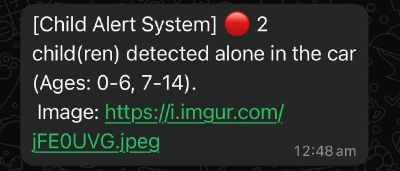

**The following image was retrieved from the Imgur link included in the alert message:**


---


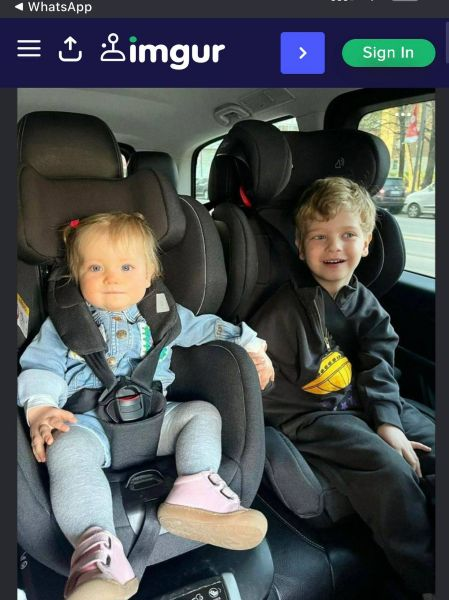